# Setting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_wisconsin_prepr

# Interpretability measures
from interpretability import PDP

NotFoundError: /shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so: undefined symbol: _ZN10tensorflow6thread10ThreadPool26TransformRangeConcurrentlyExxRKSt8functionIFvxxEE

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [ ]:
X, y, feature_names = load_wisconsin_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

NameError: name 'load_wisconsin_prepr' is not defined

# Scikit-learn models

In [ ]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier"
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear")
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_

for model_name in model_names:
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.9642857142857143
F1 = 0.9795918367346939
Accuracy = 0.9736842105263158
	class 0: 0.9285714285714286
	class 1: 1.0
Balanced accuracy (decision tree classifier) = 0.8839285714285714
F1 = 0.9261744966442952
Accuracy = 0.9035087719298246
	class 0: 0.8095238095238095
	class 1: 0.9583333333333334
Balanced accuracy (support vector classifier) = 0.9523809523809523
F1 = 0.972972972972973
Accuracy = 0.9649122807017544
	class 0: 0.9047619047619048
	class 1: 1.0


# Intrinsic interpretability

<AxesSubplot:>

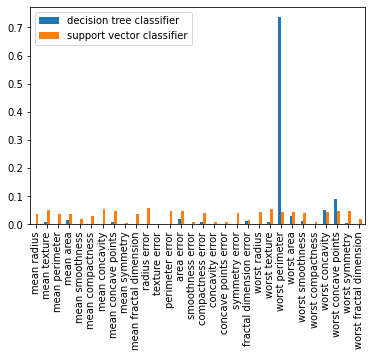

In [ ]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
feat_imps.plot.bar()

# Partial dependence plot

k-nearest neighbors


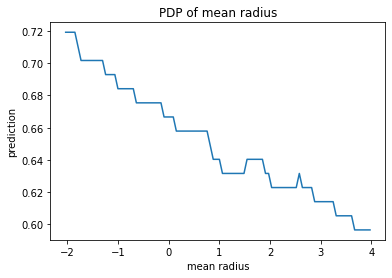

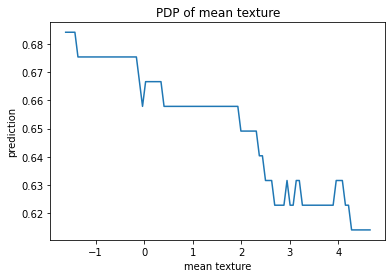

decision tree classifier


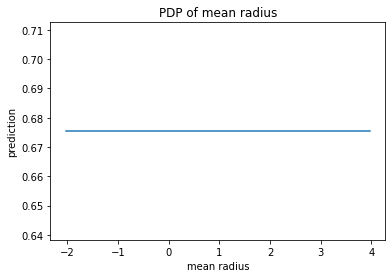

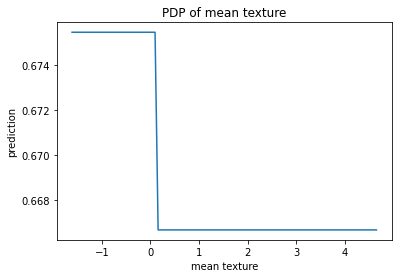

support vector classifier


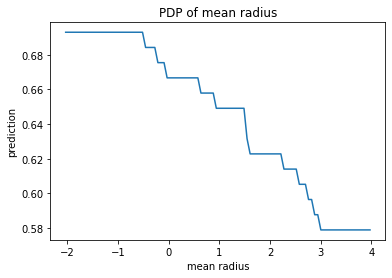

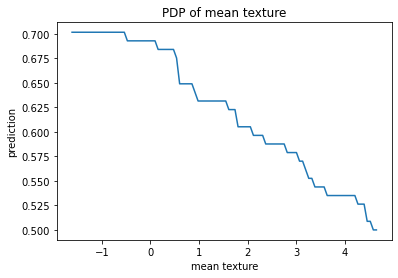

In [ ]:
for model_name in model_names:
    model = models[model_name]
    print(model_name)

    for i in range(2): # range(X_test.shape[1]):
        PDP(i, feature_names[i], model, X_test, y_test, categorical=False)
        plt.show()
        plt.close()

# SHAP

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.Explainer(models["decision tree classifier"])
shap_test = explainer(X_test_df)

shap.plots.waterfall(shap_test[:,:,1][0], max_display=10)

In [ ]:
model = models["support vector classifier"]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.KernelExplainer(model.predict, X_train)
shap_test = explainer.shap_values(X_test_df[:3]) #, nsamples=100)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
y_pred = model.predict(X_train)
y_mean = np.mean(y_pred)
y_pred = model.predict(X_test)

for k in range(114):
    if not np.abs(y_pred[k] - y_mean - np.sum(shap_test[k,:])) < 1e-14:
        print("Oei")
    # print(shap_test[k,:])
    # print(np.sum(shap_test[k,:]))
    # print(y_mean + np.sum(shap_test[k,:]))

In [ ]:
feat_imps = np.mean(np.abs(shap_test),axis=0)
feat_imps /= np.sum(feat_imps)
sort_idx = np.argsort(feat_imps)[::-1]

df = pd.DataFrame({'Shapley': feat_imps[sort_idx], 'Intrinsic': (np.abs(model.coef_[0]) / np.sum(np.abs(model.coef_[0])))[sort_idx]}, index=feature_names[sort_idx])
df.plot.bar()

<AxesSubplot:>

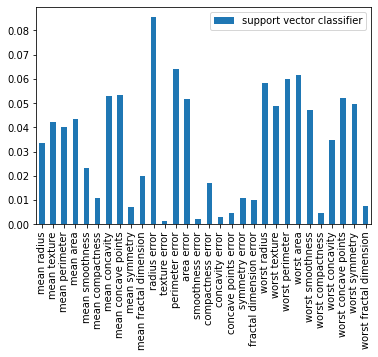

In [ ]:
shapley_feat_imps = np.mean(np.abs(shap_test),axis=0)
shapley_feat_imps /= np.sum(shapley_feat_imps)

shapley_feat_imps = pd.DataFrame({"support vector classifier": shapley_feat_imps}, index=feature_names)
shapley_feat_imps.plot.bar()

# Neural network

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 1629
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

6/6 [==============================] - 0s 10ms/step - loss: 0.0122 - binary_accuracy: 0.9975 - val_loss: 6.1343e-05 - val_binary_accuracy: 1.0000
Epoch 1131/1629
6/6 [==============================] - 0s 12ms/step - loss: 0.0037 - binary_accuracy: 1.0000 - val_loss: 6.7333e-05 - val_binary_accuracy: 1.0000
Epoch 1132/1629
6/6 [==============================] - 0s 14ms/step - loss: 0.0037 - binary_accuracy: 1.0000 - val_loss: 8.4671e-05 - val_binary_accuracy: 1.0000
Epoch 1133/1629
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - binary_accuracy: 1.0000 - val_loss: 1.3193e-04 - val_binary_accuracy: 1.0000
Epoch 1134/1629
6/6 [==============================] - 0s 14ms/step - loss: 0.0035 - binary_accuracy: 1.0000 - val_loss: 1.7001e-04 - val_binary_accuracy: 1.0000
Epoch 1135/1629
6/6 [==============================] - 0s 10ms/step - loss: 0.0035 - binary_accuracy: 1.0000 - val_loss: 1.9969e-04 - val_binary_accuracy: 1.0000
Epoch 1136/1629
6/6 [=======================

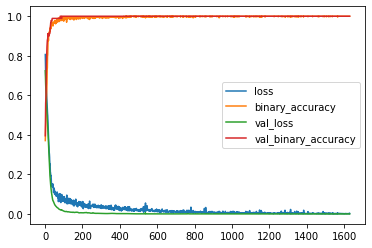

1628
(array([1628]),)


In [ ]:
for key in history.history.keys():
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

In [ ]:
model_name = "neural network"
print_errors(model, model_name, X_test, y_test)

Balanced accuracy (neural network) = 0.9523809523809523
F1 = 0.972972972972973
Accuracy = 0.9649122807017544
	class 0: 0.9047619047619048
	class 1: 1.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5161fece-8ef6-4825-9ea6-16ebba884483' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>